In [1]:
from __future__ import division
import sys
import os
import numpy as np
from matplotlib import pyplot as plt

sys.path.append("/home/tingwei/All/Machine_Learning/Image_Segmentation/models/slim")

# A place where you have downloaded a network checkpoint -- look at the previous post
checkpoints_dir = '/home/tingwei/All/Machine_Learning/Image_Segmentation/checkpoints'
sys.path.append("/home/tingwei/All/Machine_Learning/Image_Segmentation/models/slim")

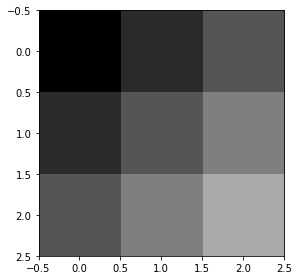

In [2]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

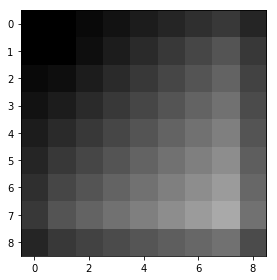

In [3]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

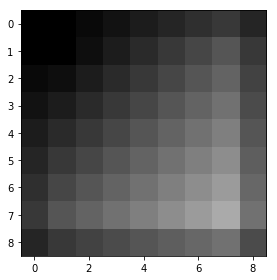

In [4]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in xrange(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor, number_of_classes)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                                 output_shape=[1, new_height, new_width, number_of_classes],
                                 strides=[1, factor, factor, 1])

                final_result = sess.run(res, feed_dict={upsample_filt_pl: upsample_filter_np,
                                             logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

In [5]:
# Test if the results of upsampling are the same
np.allclose(upsampled_img_skimage, upsampled_img_tf)

True

In [6]:
for factor in xrange(2, 10):
    
    upsampled_img_skimage = upsample_skimage(factor=factor, input_img=img)
    upsampled_img_tf = upsample_tf(factor=factor, input_img=img)
    
    are_equal = np.allclose(upsampled_img_skimage, upsampled_img_tf)
    
    print("Check for factor {}: {}".format(factor, are_equal))

Check for factor 2: True
Check for factor 3: True
Check for factor 4: True
Check for factor 5: True
Check for factor 6: True
Check for factor 7: True
Check for factor 8: True
Check for factor 9: True


INFO:tensorflow:Restoring parameters from /home/tingwei/All/Machine_Learning/Image_Segmentation/checkpoints/vgg_16.ckpt


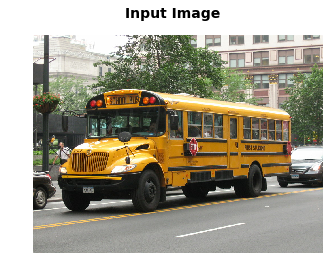

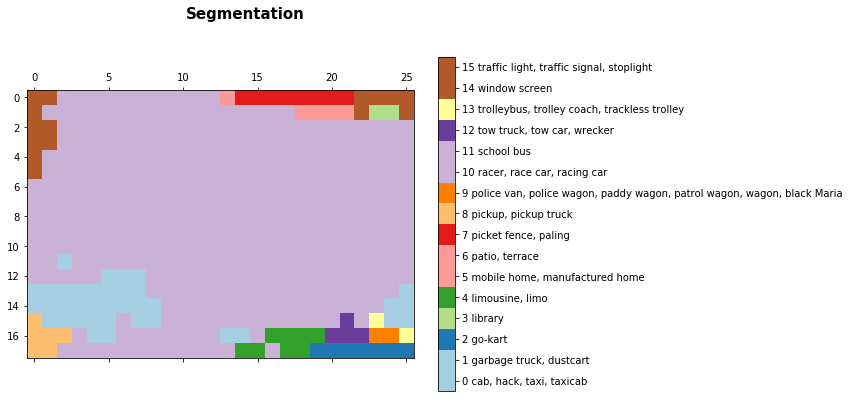

In [7]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/home/tingwei/All/Machine_Learning/Image_Segmentation/checkpoints'

slim = tf.contrib.slim

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

slim = tf.contrib.slim
# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    
    fig_size = [7, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=15, fontweight='bold')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image, np_logits = sess.run([pred, image, logits])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

names = imagenet.create_readable_names_for_imagenet_labels()

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")